In [1]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from event_clustering.preprocessing import *
from event_clustering.clustering import *
from event_clustering.postprocessing import *
from event_clustering.process_mining import *

from sklearn.cluster import *
import sklearn.metrics as metrics
import sklearn.metrics.cluster as cluster_metrics

import scipy.cluster.hierarchy as sch

# Load Encoded Events

In [5]:
file_name = 'DomesticDeclarations'
df = preprocess(load('data/' + file_name + '.xes'))
df_encoded = pd.read_csv('data/' + file_name + '_name-role_encoded.csv')
original_df_columns = df.columns

# Clustering

### KMeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


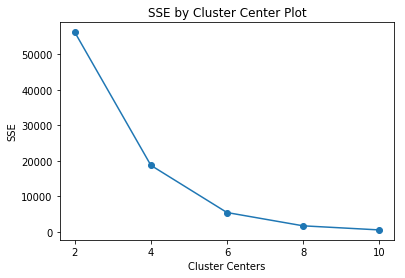

In [7]:
find_optimal_clusters(df_encoded, 10)

In [8]:
cluster_nr = 6
km = MiniBatchKMeans(n_clusters=cluster_nr, init_size=1024, batch_size=2048, random_state=20)
cluster_labels = km.fit_predict(df_encoded)

### Hierarchical Clustering

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_dendogram = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "single").fit(df_encoded)

# Plot the corresponding dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(hier_dendogram, truncate_mode='level', p=5)
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hier_dendogram, truncate_mode='level', p=40)
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

In [14]:
# --> determine amount of clusters
agg_clusters = 3
hier = AgglomerativeClustering(n_clusters=agg_clusters, linkage="single").fit(df_encoded)
cluster_labels = hier.labels_

## Evaluation

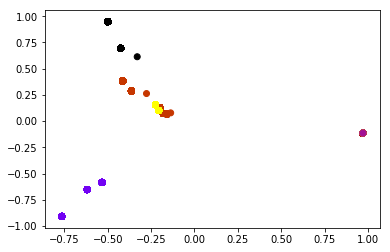

In [9]:
plot_pca(df_encoded, cluster_labels, cluster_nr)

In [327]:
print("Silhouette Coefficient KMeans: ", metrics.silhouette_score(df_encoded, cluster_labels))
print("Completeness KMeans: ", metrics.completness_score(df['case:id'], cluster_labels))

Silhouette Coefficient KMeans:  0.734592083297963


In [12]:
df['cluster_label'] = cluster_labels

## Check cluster labels "manually"

In [ ]:
#eval_manually = df_km.groupby('cluster_label')['activityNameEN'].apply(set)

In [ ]:
# group by cluster label and aggregate concept:name
eval_manually = df_hier.groupby('cluster_label')['concept:name'].apply(set)

In [ ]:
pd.set_option('display.max_colwidth', -1)
eval_manually

## Replace events with cluster representative

In [ ]:
# overwrite activityNameEN with mapped cluster representative
#abstracted_df = replace_with_representative(df_km, "activityNameEN", "cluster_label", original_df_columns)
#abstracted_df.head(5)

In [ ]:
# overwrite concept:name with mapped cluster representative
abstracted_df = replace_with_representative(df_hier, "concept:name", "cluster_label", original_df_columns)
abstracted_df.head(5)

In [ ]:
# write abstracted dataframe as csv file
csv_filename = "data/abs_km_bpic15.csv"
write_to_csv(abstracted_df, csv_filename, index=False)

# Compare Process Models from Original Dataset to Abstracted Dataset

In [ ]:
# read original and abstracted dataset as event logs
filepath_original = "data/BPIC15_1.xes"
filepath_abstracted = csv_filename

original_log = read_as_log_xes(filepath_original)
abstracted_log = read_as_log_csv(filepath_abstracted)

print("Original Log:")
print(original_log)
print("\nAbstracted Log:")
print(abstracted_log)

## Mining Algorithms
* Alpha Miner
* Inductive Miner
* Heuristic Miner
* Directly-Follows Graph

In [ ]:
# Alpha Miner
net_alpha_orig, im_alpha_orig, fm_alpha_orig = a_miner(original_log)
net_alpha, im_alpha, fm_alpha = a_miner(abstracted_log)

In [ ]:
# Inductive Miner
net_ind_orig, im_ind_orig, fm_ind_orig = ind_miner(original_log)
net_ind, im_ind, fm_ind = ind_miner(abstracted_log)

In [ ]:
# Heuristic Miner
net_heu_orig, im_heu_orig, fm_heu_orig = heu_miner(original_log)
net_heu, im_heu, fm_heu = heu_miner(abstracted_log)

In [ ]:
# Directly-Follows Graph
dfg_miner(original_log)
dfg_miner(abstracted_log)

## Process Model Metrics
* Fitness
* Precision
* Generalization
* Simplicity

In [ ]:
# Evaluation --> all four metrices in one line
print("Original Log with Heuristic Miner:")
evaluation_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
evaluation_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
print("Original Log with Inductive Miner:")
evaluation_metric(original_log, net_ind_orig, im_ind_orig, fm_ind_orig )

print("\nAbstracted Log with Inductive Miner")
evaluation_metric(abstracted_log, net_ind, im_ind, fm_ind)

In [ ]:
# Fitness
print("Original Log with Heuristic Miner:")
fitness_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
fitness_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Precision
print("Original Log with Heuristic Miner:")
precision_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
precision_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Generalization
print("Original Log with Heuristic Miner:")
generalization_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
generalization_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Simplicity
print("Original Log with Heuristic Miner:")
simplicity_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
simplicity_metric(abstracted_log, net_heu, im_heu, fm_heu)